In [ ]:
import numpy as np
from numpy import exp as exp
import matplotlib.pyplot as plt
from fit_3d import sol_3D

xx, zz = np.meshgrid(
	np.linspace(0,1,100),
	np.linspace(0,1,100)
)
plt.imshow(sol_3D(0.5,xx, zz,1.0), origin='lower')
plt.colorbar()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
def plot_quadrants(ax, array, fixed_coord, cmap):
	"""For a given 3d *array* plot a plane with *fixed_coord*, using four quadrants."""
	nx, ny, nz = array.shape
	# ax.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 1),
	#    xlabel='X', ylabel='Y', zlabel='Z')
	index = {
		'x': (nx // 2, slice(None), slice(None)),
		'y': (slice(None), ny // 2, slice(None)),
		'z': (slice(None), slice(None), nz // 2),
	}[fixed_coord]
	plane_data = array[index]

	n0, n1 = plane_data.shape
	quadrants = [
		plane_data[:n0 // 2, :n1 // 2],
		plane_data[n0 // 2:, :n1 // 2],
		plane_data[:n0 // 2, n1 // 2:],
		plane_data[n0 // 2:, n1 // 2:]
	]

	min_val = array.min()
	max_val = array.max()
	cmap = plt.get_cmap(cmap)
	xx, yy, zz = np.linspace(0,1,nx), np.linspace(0,1,ny), np.linspace(0,1,nz)

	for i, quadrant in enumerate(quadrants):
		facecolors = cmap((quadrant - min_val) / (max_val - min_val))
		if fixed_coord == 'x':
			Y, Z = np.meshgrid(yy[0:ny//2], zz[0:nz//2])
			X = 0.5 * np.ones_like(Y)
			Y_offset = (i // 2) * 0.5
			Z_offset = (i % 2) * 0.5
			ax.plot_surface(X, Y + Y_offset, Z + Z_offset, rstride=1, cstride=1,
							facecolors=facecolors, shade=False)
		elif fixed_coord == 'y':
			X, Z = np.meshgrid(xx[0:nx//2], zz[0:nz//2])
			Y = 0.5 * np.ones_like(Z)
			X_offset = (i // 2) * 0.5
			Z_offset = (i % 2) * 0.5
			ax.plot_surface(X + X_offset, Y, Z + Z_offset, rstride=1, cstride=1,
							facecolors=facecolors, shade=False)
		elif fixed_coord == 'z':
			X, Y = np.meshgrid(xx[0:nx//2], yy[0:ny//2])
			Z = 0.5 * np.ones_like(X)
			X_offset = (i // 2) * 0.5
			Y_offset = (i % 2) * 0.5
			ax.plot_surface(X + X_offset, Y + Y_offset, Z, rstride=1, cstride=1,
							facecolors=facecolors, shade=False)
		   

def figure_3D_array_slices(data, cmap='coolwarm'):
	"""Plot a 3d array using three intersecting centered planes."""
	vmin, vmax = data.min(), data.max()
	norm = colors.Normalize(vmin=vmin, vmax=vmax)
	fig = plt.figure(figsize=(10, 10))
	ax = fig.add_subplot(111, projection='3d')
	plot_quadrants(ax, data, 'x', cmap=cmap)
	plot_quadrants(ax, data, 'y', cmap=cmap)
	plot_quadrants(ax, data, 'z', cmap=cmap)
	mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
	mappable.set_array([]) 
	cbar = fig.colorbar(mappable, ax=ax, shrink=0.65)
	cbar.ax.tick_params(labelsize=14)

	
	ax.set_xlabel("X", fontsize=16)
	ax.set_ylabel("Y", fontsize=16)
	ax.set_zlabel("Z", fontsize=16)
	ax.tick_params(axis='x', labelsize=14)
	ax.tick_params(axis='y', labelsize=14)
	ax.tick_params(axis='z', labelsize=14)

	fig.tight_layout()
	return fig


In [4]:
import sys
sys.path.append('../')
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import heapq
from matplotlib import cm

from pathlib import Path
from BaseTester import BaseTester
from torch.utils.data import DataLoader
from matplotlib.lines import Line2D as mlines
from MyPlot import *

from fit_3d import hard_encode, C1ValDs
from SegModel3D import CNN
from tqdm import tqdm

def mesh(GridSize):
	h = 1.0 / (GridSize - 1)
	xx, yy= np.meshgrid(
		np.linspace(0, 1, GridSize),
		np.linspace(0, 1, GridSize),
		# np.linspace(0, 1, GridSize),
	)
	return h, xx, yy

def l2_3d(x, y, h):
	diff = (x - y)**2 * h**3
	l2_error = np.sqrt(np.sum(diff, axis=(1, 2, 3), keepdims=True))
	return l2_error

class Tester3D(BaseTester):
	def __init__(self, testN, batch_size, save_best_n, save_snapeshot_n=6, **kwargs):
		super().__init__(**kwargs)
		self.testN = testN
		self.batch_size = batch_size
		self.save_best_n = save_best_n
		self.save_snapeshot_n = save_snapeshot_n
		self.h, self.xx, self.yy = mesh(self.GridSize)
		self.test_dl = self.init_test_dl(self.testN, self.GridSize, self.dtype, self.device)
		self.nu = np.linspace(0.5, 1.5, self.testN)
	
	def load_ckpt(self, best_or_last, exp_name):
		self.load_kwargs(exp_name)
		ckpt = torch.load(f"{self.ckpt_save_path}/{exp_name}/{best_or_last}.pt", weights_only=True)

		net_kwargs = self.kwargs['net_kwargs'].copy()
		model_name = net_kwargs.pop('model_name')
		self.net = CNN(model_name, net_kwargs, self.dtype, self.device)
	
		self.net.load_state_dict(ckpt)
		self.net.eval()

	def init_test_dl(self, testN, GridSize, dtype, device):
		test_ds = C1ValDs(GridSize, testN, dtype, device)
		test_dl = DataLoader(test_ds, self.batch_size, shuffle=False, num_workers=0)
		return test_dl
	
	def save_img(self, img_save_path, pre, ans):

		pre = pre.reshape(self.GridSize, self.GridSize, self.GridSize)
		ans = ans.reshape(self.GridSize, self.GridSize, self.GridSize)
		fig = figure_3D_array_slices(pre, 'coolwarm')
		plt.savefig(f"{img_save_path}/pre.png", dpi=300, bbox_inches='tight')
		plt.close(fig)

		fig = figure_3D_array_slices(ans, 'coolwarm')
		plt.savefig(f"{img_save_path}/ref.png", dpi=300, bbox_inches='tight')
		plt.close(fig)

		fig = figure_3D_array_slices(np.abs(ans - pre), 'coolwarm')
		plt.savefig(f"{img_save_path}/diff.png", dpi=300, bbox_inches='tight')
		plt.close(fig)

	def save_best_ones(self, save_best_n, best_ones, index_start, pre, ref, batch_l2_errors):
		for i in range(len(batch_l2_errors)):
			new_one = index_start + i, self.nu[index_start + i], pre[i], ref[i], batch_l2_errors[i]
			if len(best_ones) < save_best_n:
				heapq.heappush(best_ones, new_one)
			elif new_one[-1] < best_ones[0][-1]:
				heapq.heappushpop(best_ones, new_one)
		return best_ones

	def test(self, exp_name, best_or_last='last'):
		img_save_path = Path(f"{self.img_save_path}/{exp_name}")
		if not img_save_path.is_dir():
			img_save_path.mkdir(parents=True)

		with torch.no_grad():
			self.load_kwargs(exp_name)
			self.load_ckpt(best_or_last, exp_name)

			l2_errors, best_ones = [], []
			for k, (data, ans) in tqdm(enumerate(self.test_dl)):
				index = k * self.batch_size
				pre = self.net(data)
				pre = hard_encode(pre, 0)

				pre = pre.cpu().numpy().squeeze()
				ans = ans.cpu().numpy().squeeze()
				batch_l2_error = l2_3d(pre, ans, self.h).squeeze()
				best_ones = self.save_best_ones(self.save_best_n, best_ones, index, pre, ans, batch_l2_error.squeeze())

				l2_errors += list(batch_l2_error.squeeze())
			for i, (data_idx, nu, pre, ans, l2_error) in enumerate(best_ones):
				img_save_path = Path(f"{self.img_save_path}/{exp_name}/case-{i}-{nu:.3e}")
				if not img_save_path.is_dir():	img_save_path.mkdir(parents=True)
				self.save_img(img_save_path, pre, ans)
		return l2_errors, best_ones
	


In [5]:
from itertools import product
df = {}
# for exp_name, dtype in zip(['C1Jac5-3D', 'C1Jac5-float-3D'], [torch.double, torch.double]):
for exp_name, dtype in zip(['C1Jac5-3D'], [torch.double]):
	df_best = {
		'nu':[],
		'l2':[]
	}
	tester = Tester3D(
		testN=1500, batch_size=15, save_best_n=3,
		save_snapeshot_n=5,
		area=((0,0,0), (1,1, 1)),
		GridSize=64,
		ckpt_save_path=f'model_save',
		hyper_parameters_save_path = f'hyper_parameters', 
		img_save_path = f'./images/', 
		device='cuda',
		dtype=dtype,
	)
	L2_errors, best_ones = tester.test(exp_name, 'last')
	df[exp_name] = L2_errors
	for data_idx, nu, pre, ans, l2_error in best_ones:
		df_best['nu'].append(nu)
		df_best['l2'].append(l2_error)
	df_best = pd.DataFrame(df_best)
	df_best.to_csv(f'./images/64/{exp_name}/best.csv')

df = pd.DataFrame(df)
df.to_csv(f'./images/64/L2-Errors.csv')

100it [01:59,  1.20s/it]


In [ ]:
import pandas as pd
float_df =  pd.read_csv('./images/64/L2-Errors.csv', usecols=[1])
# double_df = pd.read_csv('./images/64/L2-Errors.csv', usecols=[1])
float_data = float_df.mean(axis=0).values.item()
# double_data = double_df.mean(axis=0).values.item()

# print(f"float mean: {float_data:.4e}, \tdouble mean: {double_data:.4e}")
# print(f"float mean: {float_data:.4e}")
print(float_df.mean().item())
print(float_df.max().item())
print(float_df.min().item())
print(float_df.quantile(0.75).item())
print(float_df.quantile(0.25).item())

# print(float_df.std().item())



In [ ]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

ax = plt.figure().add_subplot(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
print(X.shape)
print(Y.shape)
print(Z.shape)


# Plot the 3D surface
# ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
		  # alpha=0.3)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph
# ax.contourf(X, Y, Z, zdir='z', offset=0, cmap='coolwarm')
# ax.contourf(X, Y, Z, zdir='x', offset=0, cmap='coolwarm')
ax.contourf(X, Y, Z, zdir='y', offset=0, cmap='coolwarm')

ax.set(xlim=(-40, 40), ylim=(-40, 40), zlim=(-100, 100),
	xlabel='X', ylabel='Y', zlabel='Z')

plt.show()

4.499634700129972e-05


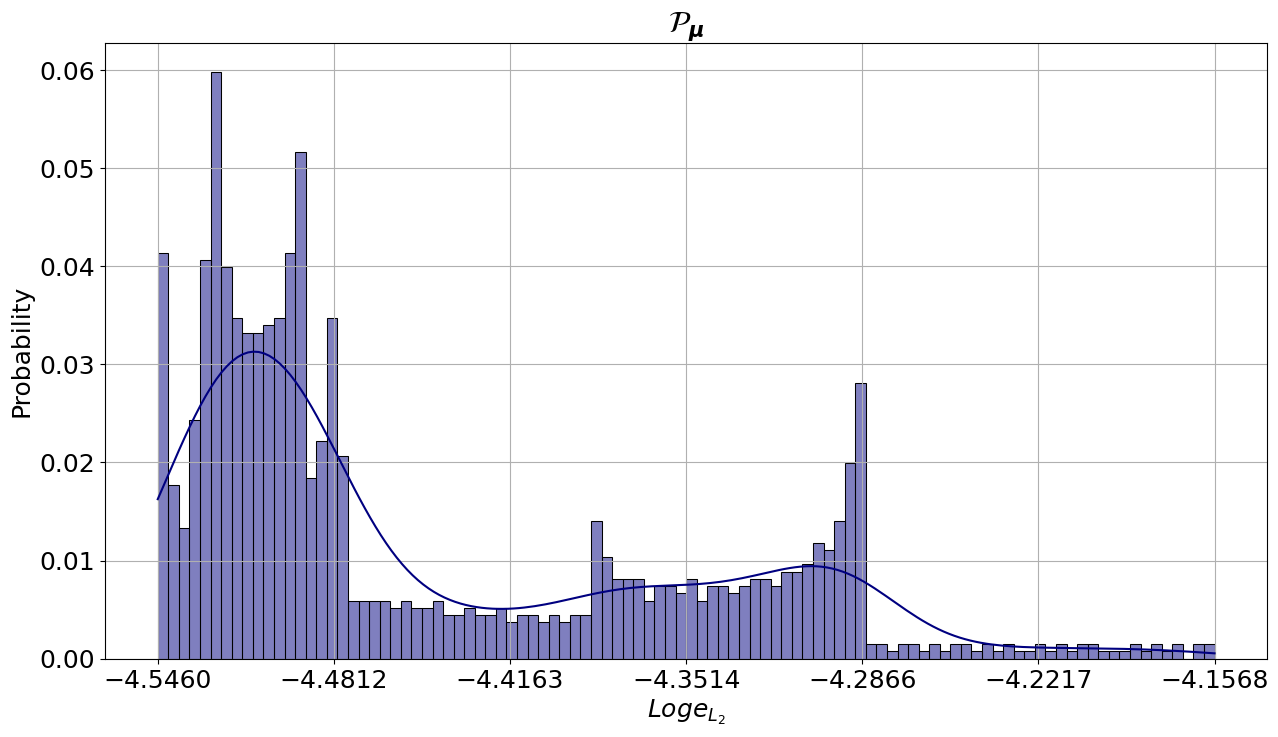

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df = pd.read_csv('images/64/L2-Errors.csv')

fig = plt.figure(figsize=(15, 8))  # Set the figure size
plt.rcParams['font.size'] = 18  # Default font size
# data = np.log10(df['C1Jac5-3D'].values)
data = df['C1Jac5-3D'].values

data = np.log10(data[data <=7e-5])

sns.histplot(
data,
bins=100,  # Number of bins
kde=True,  # Add KDE (Kernel Density Estimate)
stat='probability',  # Normalize the histogram
color='navy',  # Color of the bars
edgecolor='black'  # Color of the edges
)
print(df['C1Jac5-3D'].mean())

# Customization
plt.title(r'$\mathcal{P}_\boldsymbol{\mu}$')  # Title of the plot
plt.xlabel('$Log e_{L_2}$')  # X-axis label
plt.xticks(np.linspace(data.min(), data.max(), 7))
plt.ylabel('Probability')  # Y-axis label
plt.grid(True)  # Show grid lines
plt.show()
fig.savefig(f'test_all.png')
plt.close()
